# Descrição do algoritmo

Este algoritmo tem como objetivo avaliar diversos classificadores. Para decidir qual deles será utilizado para classificar os dados de teste da competição. 


# Critério de avaliação.
 
O melhor modelo será escolhido aquele que conseguir o melhor valor de f1-score.
 
Uma outra métrica também será utilizada para avaliar o classificador, no caso o log-loss. 
 



# Log-loss
$H(q) = -\frac{1}{N}\sum_{i =1}^{N}y_{i}*log(p(y_{i})) + (1 - y_{i})*log(1 - p(y_{i}))$
 
#####$H(q)$ - > Log Loss
N -> Número de eventos
 
$y_{i}$ -> Valor da classe
$p(y_{i})$ -> probabilidade calculada do dado pertence esta classe
 
---
### Interpretação da equação
Esta equação penaliza a classificação errada. No caso quanto maior a distância da probabilidade calculada do valor da classe original maior será a penalidade.
 
####Quanto mais próximo o valor de log-loss for de 0. Melhor será o resultado da classificação. 
---
 
 
 
 
 



# Modelos utilizados.
 
> Floresta aleatória
 
> ExtraTrees
 
> Regressão logística (Dados normalizados pelo MinMax)
 
> Regressão logística (Dados normalizados pelo desvio padrão)
 
> KNN (Dados normalizados pelo MinMax)
 
> KNN (Dados normalizados pelo desvio padrão)
 
> XGBoost
 
> MLP (Dados normalizados pelo desvio padrão)
 
---
 
> Um outro modelo também que será avaliado é um baseado em **Staking**. O primeiro nível dele são as probabilidades dos classificadores anteriores, o segundo nível é uma regressão logística.


#Biblioteca

In [ ]:

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importando os dados

In [ ]:
df_trein = pd.read_csv('/content/drive/My Drive/Competição FLAI/treino.csv') # dados usados para treinamento
df_teste = pd.read_csv('/content/drive/My Drive/Competição FLAI/teste.csv')  # dados usado  para teste

# Codificando as váriavies do tipo string

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
def enconder_label(col,df):

  for i in range(len(col)):
    enc = LabelEncoder()
    inteiros = enc.fit_transform(df[col[i]])
    df[col[i]] = inteiros

  return df

In [ ]:
# teste da combinação 1
def enconder_label_p1(df):
  df['term_deposit'] = df['term_deposit'].map({'no': 0, 'yes': 1})
  df['default']   = df['default'].map({'no': 0, 'yes': 1})
  df['housing']   = df['housing'].map({'no': 0, 'yes': 1})
  df['loan']      = df['loan'].map({'no': 0, 'yes': 1})
  df['education'] = df['education'].map({"primary": 0, "secondary":1, "tertiary":2,"unknown":3})

  df['poutcome'] = df['poutcome'].map({"unknown": 0, "failure":1, "other":2, "success":3})
  df['contact'] =  df['contact'].map({"cellular": 0, "unknown":1, "telephone":2})

  coluna      = ['job','marital','month']

  for i in range(len(coluna)):
      df = df.join(pd.get_dummies(df[coluna[i]], prefix=coluna[i]))
      df = df.drop(columns=coluna[i])

  df.drop(columns = 'Unnamed: 0')
  return df

In [ ]:
# teste da combinação 2 (Melhor resultado)
def enconder_label_p2(df):
  coluna   = [ 'marital','contact','month']

  df['term_deposit'] = df['term_deposit'].map({'no': 0, 'yes': 1})
  df['housing']      = df['housing'].map({'no': 0, 'yes': 1})
  df['loan']         = df['loan'].map({'no': 0, 'yes': 1})
  df['education']    = df['education'].map({"primary": 0, "secondary":1, "tertiary":2,"unknown":3})
  df['poutcome']     = df['poutcome'].map({"failure": 0, "other":1, "success":2, "unknown":3})
  df['job']          = df['job'].map({"admin.": 0, "blue-collar":1, "entrepreneur":2, "housemaid":3, "management":4,"retired":5,"self-employed":6,"services":7,"student":8,"technician":9,"unemployed":10,"unknown":11})
  
  df['default']   = df['default'].map({'no': 0, 'yes': 1})
  
  df = df.drop(columns = 'Unnamed: 0')

  for i in range(len(coluna)):
      df = df.join(pd.get_dummies(df[coluna[i]], prefix=coluna[i]))
      df = df.drop(columns=coluna[i])
  return df

In [ ]:
df_aux  = df_trein.copy()

In [ ]:
df_aux = enconder_label_p2(df_aux) # melhor combinação realizada dos testes que já foram feitos

#Avaliando os modelos escolhidos  
#####Primeiro nível e avaliando demais classificadores escolhidos com o intervalo de corte de 0.4
---
As probabilidades calculadas das classes serão utilizadas como primeiro nível do Staking. 
 



In [ ]:
X  = df_aux.drop(columns='term_deposit') # variáveis preditores 
y = df_aux['term_deposit'] # variáável de target
    

In [ ]:
acerto_f1      = np.zeros((8,10)) # matrix de f1
acerto_log     = np.zeros((8,10)) # matrix de log loss

In [ ]:
kf = KFold(n_splits=10, random_state=5, shuffle=True)
j = 0

second_level = np.zeros((X.shape[0], 8)) # dados de entrada do modelo stacking

for tr, ts in kf.split(X,y):
    Xtr, Xval = X.iloc[tr], X.iloc[ts]
    ytr, yval = y.iloc[tr], y.iloc[ts]
    
    # floresta aleatoria
    rf = RandomForestClassifier(n_estimators=1000, n_jobs=6, random_state=10)
    rf.fit(Xtr, ytr)
    prf = rf.predict_proba(Xval)[:,1]
    prf_ = (prf > 0.4).astype(int)

    acerto_f1[0,j] = f1_score(yval, prf_)
    acerto_log[0,j] = log_loss(yval, prf)
    
    # Estratrees
    et = ExtraTreesClassifier(n_estimators=1000, n_jobs=6, random_state=10)
    et.fit(Xtr, ytr)
    pet = et.predict_proba(Xval)[:,1]
    pet_ = (pet > 0.4).astype(int)
    
    acerto_f1[1,j] = f1_score(yval, pet_)
    acerto_log[1,j] = log_loss(yval, pet)

    # regressão logistica normalizada pelo desvio padrão
    lr1 = make_pipeline(StandardScaler(), LogisticRegression())
    lr1.fit(Xtr, ytr)
    plr1 = lr1.predict_proba(Xval)[:,1]
    plr1_ = (plr1 > 0.4).astype(int)

    acerto_f1[2,j] = f1_score(yval, plr1_)
    acerto_log[2,j] = log_loss(yval, plr1)
    
    # regressão logistica normalizada pelo minmax
    lr2 = make_pipeline(MinMaxScaler(), LogisticRegression())
    lr2.fit(Xtr, ytr)
    plr2 = lr2.predict_proba(Xval)[:,1]
    plr2_ = (plr2 > 0.4).astype(int)

    acerto_f1[3,j] = f1_score(yval, plr2_)
    acerto_log[3,j] = log_loss(yval, plr2)
    
    # regressão knn normalizada pelo minmax
    knn1 = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=100))
    knn1.fit(Xtr, ytr)
    klr1 = knn1.predict_proba(Xval)[:,1]
    klr1_ = (klr1 > 0.4).astype(int)

    acerto_f1[4,j] = f1_score(yval, klr1_)
    acerto_log[4,j] = log_loss(yval, klr1)

    # regressão knn normalizada pelo desvio padrão
    knn2 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=100))
    knn2.fit(Xtr, ytr)
    klr2 = knn2.predict_proba(Xval)[:,1]
    klr2_ = (klr2 > 0.4).astype(int)

    acerto_f1[5,j] = f1_score(yval, klr2_)
    acerto_log[5,j] = log_loss(yval, klr2)

    # XGB 
    XGB = XGBClassifier(n_estimators=1000, n_jobs=6, random_state=10)
    XGB.fit(Xtr, ytr)
    XGBlr2 = XGB.predict_proba(Xval)[:,1]
    XGB_ = (XGBlr2 > 0.4).astype(int)

    acerto_f1[6,j] = f1_score(yval, XGB_)
    acerto_log[6,j] = log_loss(yval, XGBlr2)

    # MLP classificador
    clf = MLPClassifier(hidden_layer_sizes=[30,30], solver='adam', alpha=1e-5, random_state=1, max_iter=1000)
    clf2 = make_pipeline(StandardScaler(), clf)

    clf2.fit(Xtr, ytr)
    clfp = clf2.predict_proba(Xval)[:,1]
    clfp_ = (clfp > 0.4).astype(int)

    acerto_f1[7,j] = f1_score(yval, clfp_)
    acerto_log[7,j] = log_loss(yval, clfp)

    second_level[ts, 0] = prf
    second_level[ts, 1] = pet
    second_level[ts, 2] = plr1
    second_level[ts, 3] = plr2
    second_level[ts, 4] = klr1
    second_level[ts, 5] = klr2
    second_level[ts, 6] = XGBlr2
    second_level[ts, 7] = clfp


    j = j + 1

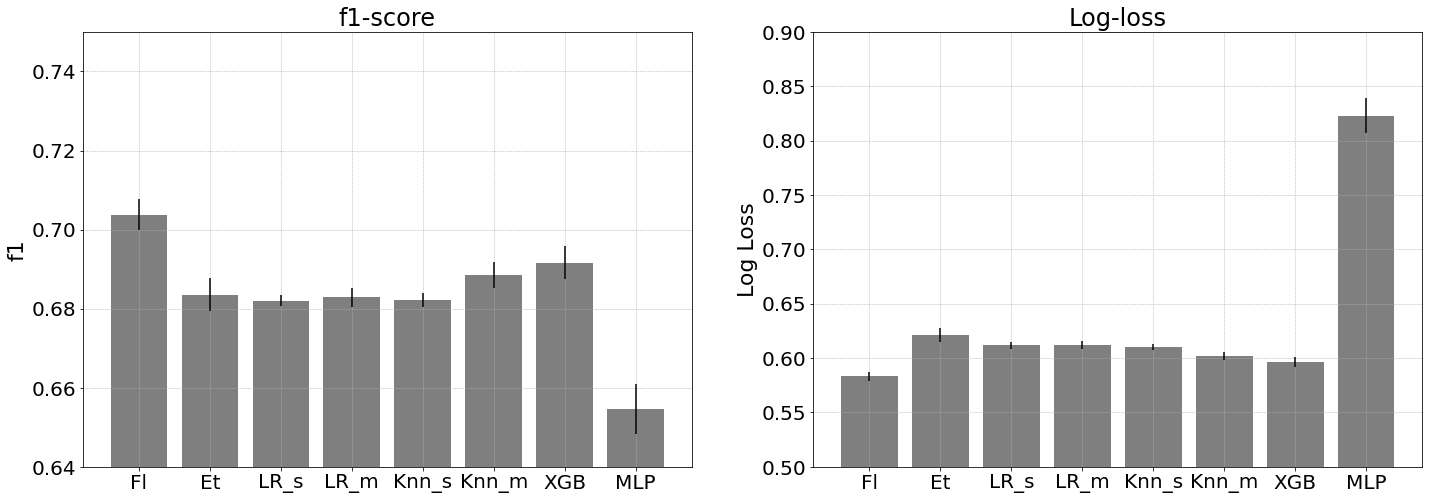

In [ ]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

plt.figure(figsize= (24,8))
plt.subplot(1,2,1)
plt.title('f1-score',fontsize = 24)
langs = ['Fl', 'Et', 'LR_s', 'LR_m', 'Knn_s','Knn_m','XGB','MLP']
plt.bar(langs,np.mean(acerto_f1,axis =  1),yerr = np.std(acerto_f1,axis =  1)/np.sqrt(10),color = 'black',alpha =0.5)
plt.ylabel('f1',fontsize = 22)
plt.ylim(0.64,.75)
plt.grid(linestyle='--', linewidth=0.5)


plt.subplot(1,2,2)
plt.title('Log-loss',fontsize = 24)
langs = ['Fl', 'Et', 'LR_s', 'LR_m', 'Knn_s','Knn_m','XGB','MLP']
plt.bar(langs,np.mean(acerto_log,axis =  1),yerr = np.std(acerto_log,axis =  1)/np.sqrt(10), color = 'black',alpha =0.5)
plt.ylabel('Log Loss',fontsize = 22)
plt.ylim(0.5,.9)
plt.grid(linestyle='--', linewidth=0.5)


plt.show()




Legenda dos classificadores
 
---
 
> fl -> Floresta aleatória
 
> Et -> ExtraTrees
 
> LR_s -> Regressão logística (Dados normalizados pelo MinMax)
 
> LR_s -> Regressão logística (Dados normalizados pelo desvio padrão)
 
> Knn_s -> KNN (Dados normalizados pelo MinMax)
 
> Knn_s -> KNN (Dados normalizados pelo desvio padrão)
 
> XGB -> XGBoost
 
> Multilayer perceptron -> MLP (Dados normalizados pelo desvio padrão)


# Floresta aleatória modelo 2


In [ ]:
c = np.arange(0.30,0.5,0.01)

In [ ]:
acerto_f_A = np.zeros((len(c),10)) # matrix intervalo de cortes 
acerto_l_A = np.zeros(10) # matrix log-loss


kf = KFold(n_splits=10, random_state=5, shuffle=True)
for i in range(len(c)):
  j= 0
  for tr, ts in kf.split(X,y):
    Xtr, Xval = X.iloc[tr], X.iloc[ts]
    ytr, yval = y.iloc[tr], y.iloc[ts]
    
    # floresta aleatoria
    rf = RandomForestClassifier(n_estimators=1000, n_jobs=6, random_state=10)
    rf.fit(Xtr, ytr)
    prf = rf.predict_proba(Xval)[:,1]
    prf_ = (prf > c[i]).astype(int)

    acerto_f_A[i,j] = f1_score(yval, prf_)

    acerto_l_A[j] = log_loss(yval, prf)

    j= j + 1

In [ ]:
for i in range(len(c)):
  print('Corte',str(c[i]))
  print('f1:',np.format_float_positional(np.mean(acerto_f_A[i]),5),'Erro:',np.format_float_positional(np.std(acerto_f_A[i])/np.sqrt(10),5),'Desvio padrão:',np.format_float_positional(np.std(acerto_f_A[i]),5))
  print('\n')

Corte 0.3
f1: 0.69325 Erro: 0.00394 Desvio padrão: 0.01246


Corte 0.31
f1: 0.69484 Erro: 0.00374 Desvio padrão: 0.01181


Corte 0.32
f1: 0.69573 Erro: 0.00359 Desvio padrão: 0.01136


Corte 0.33
f1: 0.69814 Erro: 0.00416 Desvio padrão: 0.01316


Corte 0.34
f1: 0.69995 Erro: 0.00400 Desvio padrão: 0.01266


Corte 0.35000000000000003
f1: 0.70138 Erro: 0.00406 Desvio padrão: 0.01283


Corte 0.36000000000000004
f1: 0.70309 Erro: 0.00386 Desvio padrão: 0.01221


Corte 0.37000000000000005
f1: 0.70452 Erro: 0.00393 Desvio padrão: 0.01241


Corte 0.38000000000000006
f1: 0.70486 Erro: 0.00420 Desvio padrão: 0.01329


Corte 0.39000000000000007
f1: 0.70603 Erro: 0.00399 Desvio padrão: 0.01262


Corte 0.4000000000000001
f1: 0.70380 Erro: 0.00387 Desvio padrão: 0.01223


Corte 0.4100000000000001
f1: 0.70315 Erro: 0.00351 Desvio padrão: 0.0111


Corte 0.4200000000000001
f1: 0.70315 Erro: 0.00356 Desvio padrão: 0.01126


Corte 0.4300000000000001
f1: 0.70191 Erro: 0.00357 Desvio padrão: 0.01129


Cor

In [ ]:
print('f1:',np.format_float_positional(np.mean(acerto_l_A),5),'Erro:',np.format_float_positional(np.std(acerto_l_A)/np.sqrt(10),5),'Desvio padrão:',np.format_float_positional(np.std(acerto_l_A),5))

f1: 0.58312 Erro: 0.00433 Desvio padrão: 0.01370


In [ ]:
f1 = []
f1s = []

loss = []
loss_s = []
for i in range(8):
  f1.append(np.mean(acerto_f1,axis =  1)[i])
  f1s.append(np.std(acerto_f1,axis =  1)[i])

  loss.append(np.mean(acerto_log,axis =  1)[i])
  loss_s.append(np.std(acerto_log,axis =  1)[i])


In [ ]:
a = np.mean(acerto_f_A,axis = 1)
b = np.std(acerto_f_A,axis = 1)

f1.append(np.max(a))
f1s.append(np.max(b[np.argmax(a)]))

loss.append(np.mean(acerto_l_A))
loss_s.append(np.std(acerto_l_A))

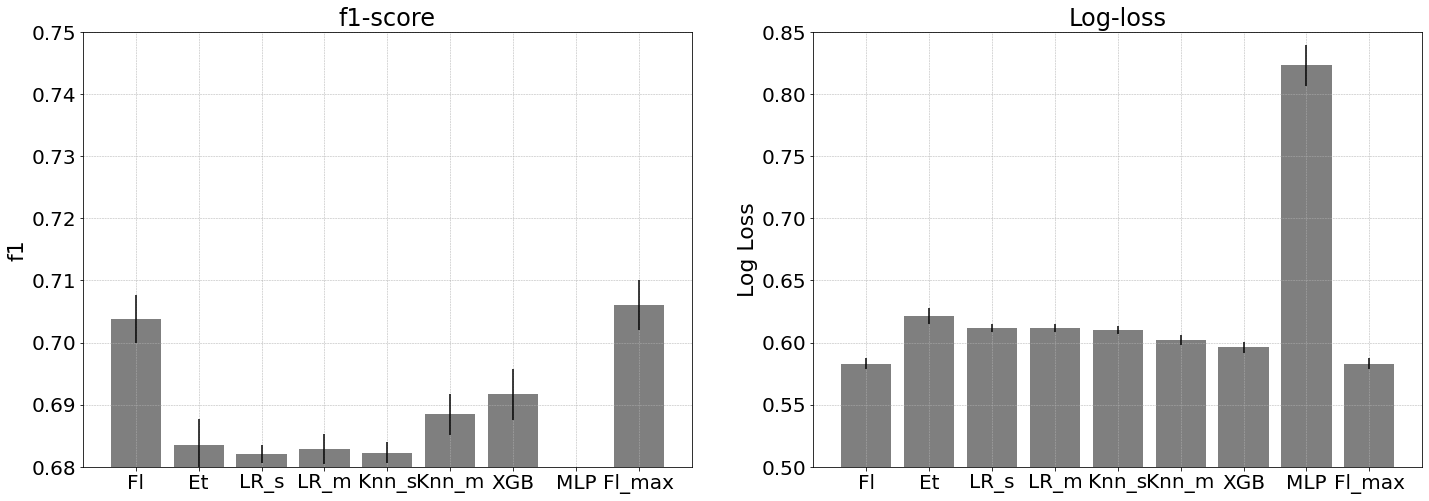

In [ ]:
langs = ['Fl', 'Et', 'LR_s', 'LR_m', 'Knn_s','Knn_m','XGB','MLP','Fl_max']
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

plt.figure(figsize= (24,8))
plt.subplot(1,2,1)
plt.title('f1-score',fontsize = 24)
plt.bar(langs,np.array(f1),yerr = np.array(f1s)/np.sqrt(10),color = 'black',alpha =0.5)
plt.ylabel('f1',fontsize = 22)
plt.ylim(0.63,.75)
plt.grid(linestyle='--', linewidth=0.5)


plt.subplot(1,2,2)
plt.title('Log-loss',fontsize = 24)
plt.bar(langs,np.array(loss),yerr = np.array(loss_s)/np.sqrt(10), color = 'black',alpha =0.5)
plt.ylabel('Log Loss',fontsize = 22)
plt.ylim(0.5,.85)
plt.grid(linestyle='--', linewidth=0.5)


plt.show()





# Staking 

In [ ]:
df = pd.DataFrame(second_level,columns=['Fl', 'Et', 'LR_s', 'LR_m', 'Knn_s','Knn_m','XGB','MLP'])

### Olhando a correlação do primeiro nível


In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Fl,Et,LR_s,LR_m,Knn_s,Knn_m,XGB,MLP
Fl,1.000000,0.930240,0.741208,0.740190,0.787218,0.796086,0.837798,0.729858
Et,0.930240,1.000000,0.687897,0.688674,0.735649,0.753445,0.749116,0.743463
LR_s,0.741208,0.687897,1.000000,0.996217,0.840031,0.901573,0.731107,0.573846
LR_m,0.740190,0.688674,0.996217,1.000000,0.853002,0.906574,0.728129,0.570325
Knn_s,0.787218,0.735649,0.840031,0.853002,1.000000,0.906705,0.724840,0.607219
Knn_m,0.796086,0.753445,0.901573,0.906574,0.906705,1.000000,0.762104,0.637762
XGB,0.837798,0.749116,0.731107,0.728129,0.724840,0.762104,1.000000,0.652821
MLP,0.729858,0.743463,0.573846,0.570325,0.607219,0.637762,0.652821,1.000000


Mesmo tendo uma alta correlação entre algumas variáveis, será realizado um primeiro teste com todos os classificadores.
 

In [ ]:
c          = np.arange(0.1,0.9,0.01)
acerto_v   = np.zeros((len(c),10))
acerto_v1  = np.zeros(10) 

j = 0

kf = KFold(n_splits=10,random_state=5, shuffle=True)
for i in range(len(c)):
  j = 0
  for tr, ts in kf.split(X,y):
    
    Xtr, Xval = second_level[tr], second_level[ts]
    ytr, yval = y.iloc[tr], y.iloc[ts]
        
    lr_stack = LogisticRegression(C = 1.,max_iter = 5000)
    lr_stack.fit(Xtr, ytr)
    plr_stack = lr_stack.predict_proba(Xval)[:,1]
    plr_stack_ = (plr_stack > c[i]).astype(int)
      
    acerto_v[i,j]  = f1_score(yval, plr_stack_)
    acerto_v1[j]   = log_loss(yval, plr_stack)

    j= j + 1

In [ ]:
for i in range(len(c)):
  print('Corte',str(c[i]))
  print('f1:',np.format_float_positional(np.mean(acerto_v[i]),5),'Erro:',np.format_float_positional(np.std(acerto_v[i])/np.sqrt(10),5),'Desvio padrão:',np.format_float_positional(np.std(acerto_v[i]),5))
  print('\n')

Corte 0.1
f1: 0.66437 Erro: 0.00379 Desvio padrão: 0.01199


Corte 0.11
f1: 0.66471 Erro: 0.00388 Desvio padrão: 0.01228


Corte 0.12
f1: 0.66555 Erro: 0.00377 Desvio padrão: 0.01191


Corte 0.13
f1: 0.66659 Erro: 0.00423 Desvio padrão: 0.01337


Corte 0.13999999999999999
f1: 0.66763 Erro: 0.00430 Desvio padrão: 0.01361


Corte 0.14999999999999997
f1: 0.67037 Erro: 0.00381 Desvio padrão: 0.01205


Corte 0.15999999999999998
f1: 0.67216 Erro: 0.00338 Desvio padrão: 0.01069


Corte 0.16999999999999998
f1: 0.67469 Erro: 0.00364 Desvio padrão: 0.01152


Corte 0.17999999999999997
f1: 0.67611 Erro: 0.0034 Desvio padrão: 0.01074


Corte 0.18999999999999995
f1: 0.67831 Erro: 0.00363 Desvio padrão: 0.01147


Corte 0.19999999999999996
f1: 0.67996 Erro: 0.00354 Desvio padrão: 0.01119


Corte 0.20999999999999996
f1: 0.68244 Erro: 0.00355 Desvio padrão: 0.01122


Corte 0.21999999999999995
f1: 0.68358 Erro: 0.00402 Desvio padrão: 0.01271


Corte 0.22999999999999995
f1: 0.68521 Erro: 0.0043 Desvio pad

In [ ]:
a = np.mean(acerto_v,axis = 1)
b = np.std(acerto_v,axis = 1)

f1.append(np.max(a))
f1s.append(np.max(b[np.argmax(a)]))

loss.append(np.mean(acerto_v1))
loss_s.append(np.std(acerto_f1))

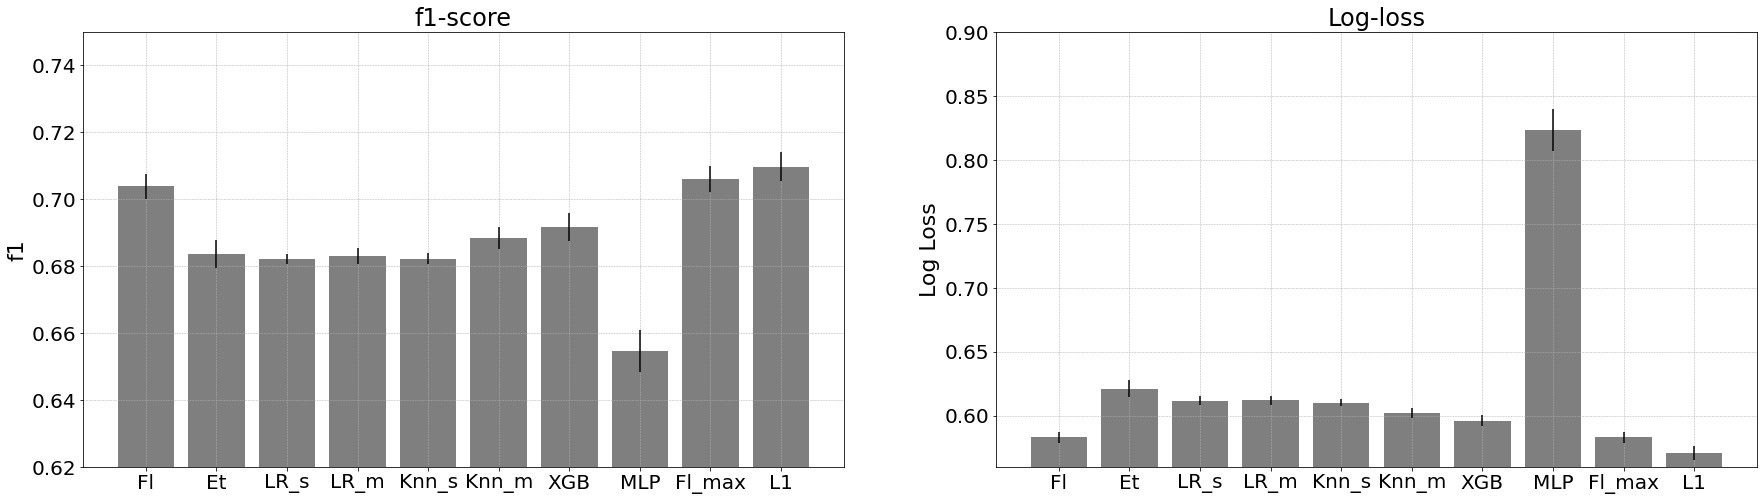

In [ ]:
langs = ['Fl', 'Et', 'LR_s', 'LR_m', 'Knn_s','Knn_m','XGB','MLP','Fl_max','L1']
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

plt.figure(figsize= (30,8))
plt.subplot(1,2,1)
plt.title('f1-score',fontsize = 24)
plt.bar(langs,np.array(f1),yerr = np.array(f1s)/np.sqrt(10),color = 'black',alpha =0.5)
plt.ylabel('f1',fontsize = 22)
plt.ylim(0.62,.75)
plt.grid(linestyle='--', linewidth=0.5)


plt.subplot(1,2,2)
plt.title('Log-loss',fontsize = 24)
plt.bar(langs,np.array(loss),yerr = np.array(loss_s)/np.sqrt(10), color = 'black',alpha =0.5)
plt.ylabel('Log Loss',fontsize = 22)
plt.ylim(0.56,.9)
plt.grid(linestyle='--', linewidth=0.5)


plt.show()





> FL_max - > Floresta aleatória com o ponto de corte otimizado
 
> L1 - > Staking com o ponto de corte otimizado
 
---
 
O melhor resultado atingido foi com o modelo L1 e um de limiar de 0.35. Este limiar pode estar privilegiando só os acertos verdadeiros positivos. Por causa deste motivo também será avaliado a precisão em relação ao acerto dos verdadeiros negativos. Esta análise também será feita pelo fato que se os dados de teste tiverem mais dados de classe 0, o limiar deverá ser mudado. **(análise futura)** 
 
---
 
Como posso enviar 5 submissões. Eu irei enviar os dados de teste com o valor de limiar com melhor desempenho de f1-score para o modelo. Se o desepenho for ruim irei aplicar análise que foi dita anterior
 
 
 



# Olhando o melhor valor

In [ ]:
print('f1-score:',f1[-1],'desvio padrão',f1s[-1],' erro:',np.array(f1s[-1])/np.sqrt(10))
print('log-loss:',loss[-1],'desvio padrão',loss_s[-1],'erro:',np.array(loss_s[-1])/np.sqrt(10))

f1-score: 0.7097260287725455 desvio padrão 0.01380461187742042  erro: 0.0043654015747261665
log-loss: 0.5705773237755702 desvio padrão 0.017496469764743575 erro: 0.005532869546886011


# Envia os resultado pelo staking

In [ ]:
def enconder_label_p2_teste(df):
  coluna   = [ 'marital','contact','month']
  #col      = ['default''housing','loan','job','education','poutcome']

  #col                = ['job']
#  df['term_deposit'] = df['term_deposit'].map({'no': 0, 'yes': 1})
  df['housing']      = df['housing'].map({'no': 0, 'yes': 1})
  df['loan']         = df['loan'].map({'no': 0, 'yes': 1})
  df['education']    = df['education'].map({"primary": 0, "secondary":1, "tertiary":2,"unknown":3})
  df['poutcome']     = df['poutcome'].map({"failure": 0, "other":1, "success":2, "unknown":3})
  df['job']          = df['job'].map({"admin.": 0, "blue-collar":1, "entrepreneur":2, "housemaid":3, "management":4,"retired":5,"self-employed":6,"services":7,"student":8,"technician":9,"unemployed":10,"unknown":11})
  #df  = df.copy()
  
  df['default']   = df['default'].map({'no': 0, 'yes': 1})
  
  
  #df  = enconder_label(col,df)
  df = df.drop(columns = 'Unnamed: 0')
  #df1  = enconder_label(col,df1)

  #df_teste = enconder_label(col,df_teste)

  #print('a')
  for i in range(len(coluna)):
      df = df.join(pd.get_dummies(df[coluna[i]], prefix=coluna[i]))
      df = df.drop(columns=coluna[i])

    # df_teste = df_teste.join(pd.get_dummies(df_teste[coluna[i]], prefix=coluna[i]))
    # df_teste = df_teste.drop(columns=coluna[i])

  return df

In [ ]:
df_teste = enconder_label_p2_teste(df_teste)

In [ ]:
X_teste  = df_teste

In [ ]:


second_level_teste = np.zeros((X_teste.shape[0], 8))


   
# floresta aleatoria
rf = RandomForestClassifier(n_estimators=1000, n_jobs=6, random_state=10)
rf.fit(X, y)
prf = rf.predict_proba(X_teste)[:,1]


# Estratrees
et = ExtraTreesClassifier(n_estimators=1000, n_jobs=6, random_state=10)
et.fit(X, y)
pet = et.predict_proba(X_teste)[:,1]
       
# regressão logistica normalizada pelo desvio padrãão
lr1 = make_pipeline(StandardScaler(), LogisticRegression())
lr1.fit(X, y)
plr1 = lr1.predict_proba(X_teste)[:,1]
      
# regressão logistica normalizada pelo minmax
lr2 = make_pipeline(MinMaxScaler(), LogisticRegression())
lr2.fit(X, y)
plr2 = lr2.predict_proba(X_teste)[:,1]
  
# regressão knn normalizada pelo minmax
knn1 = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=100))
knn1.fit(X, y)
klr1 = knn1.predict_proba(X_teste)[:,1]

# regressão knn normalizada pelo desvio padrãão
knn2 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=100))
knn2.fit(X, y)
klr2 = knn2.predict_proba(X_teste)[:,1]
  
# XGB 
XGB = XGBClassifier(n_estimators=1000, n_jobs=6, random_state=10)
XGB.fit(X, y)
XGBlr2 = XGB.predict_proba(X_teste)[:,1]

# MLP classificador
clf = MLPClassifier(hidden_layer_sizes=[30,30], solver='adam', alpha=1e-5, random_state=1, max_iter=1000)
clf2 = make_pipeline(StandardScaler(), clf)

clf2.fit(X, y)
clfp = clf2.predict_proba(X_teste)[:,1]
    


second_level_teste[:, 0] = prf
second_level_teste[:, 1] = pet
second_level_teste[:, 2] = plr1
second_level_teste[:, 3] = plr2
second_level_teste[:, 4] = klr1
second_level_teste[:, 5] = klr2
second_level_teste[:, 6] = XGBlr2
second_level_teste[:, 7] = clfp

# fatores de diversidade

In [ ]:
c = np.arange(0.1,1,0.01)[ind]

X = second_level
X_T = second_level_teste
        
lr_stack = LogisticRegression(C = 1.,max_iter = 5000)
lr_stack.fit(X, y)
plr_stack = lr_stack.predict_proba(X_T)[:,1]
plr_stack_ = (plr_stack > 0.35).astype(int)    

In [ ]:
plr_stack_

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
predicao_final = pd.DataFrame()
predicao_final['term_deposit'] = plr_stack_
predicao_final

,term_deposit
0,0
1,0
2,0
3,0
4,1
...,...
1417,1
1418,1
1419,1
1420,1


In [ ]:
predicao_final.to_csv('/content/drive/My Drive/Competição FLAI/Submissão.csv', index = False)

# Enviar o resultado da floresta aleatoria

In [ ]:
X  = df_aux.drop(columns='term_deposit')
y = df_aux['term_deposit']
    

In [ ]:
# floresta aleatoria
rf = RandomForestClassifier(n_estimators=1000, n_jobs=6, random_state=10)
rf.fit(X, y)
prf = rf.predict_proba(X_teste)[:,1]
prf_ = (prf > 0.4).astype(int)

In [ ]:
#X_teste

In [ ]:
predicao_final = pd.DataFrame()
predicao_final['term_deposit'] = prf_
predicao_final

,term_deposit
0,0
1,0
2,0
3,0
4,1
...,...
1417,1
1418,1
1419,1
1420,1


In [ ]:
predicao_final.to_csv('/content/drive/My Drive/Competição FLAI/Submissão1.csv', index = False)

# Referências
https://medium.com/ensina-ai/uma-explica%C3%A7%C3%A3o-visual-para-fun%C3%A7%C3%A3o-de-custo-binary-cross-entropy-ou-log-loss-eaee662c396c

https://github.com/ledmaster/notebooks_tutoriais/tree/master/live17_stacking 

# Conclusão
 
Temos as seguintes conclusões:
* O melhor modelo que atingiu a melhor performance foi o staking com o resultado de 0.7198. Este resultado foi o melhor da competição.
 
* Outros testes podem ser feitos como a discretização da variável age, encontrar os melhores parâmetros dos modelos que foram utilizados e eliminar os classificadores do level 1 do staking que apresentaram uma alta correlação.
 

